This file will include most of the tests run in the first paper we published, just to ensure that results replicate. 

In [ ]:
%%capture
!pip install transformers --upgrade
!pip install mosestokenizer
!pip install sentencepiece
!pip install ast

In [ ]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from google.colab import drive
import re
from bs4 import BeautifulSoup

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
'''
Construct object in BERT sentiment classifier class
'''
sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden states.
)

sentiment_model.cuda() # Puts model on GPU

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
'''
Load pretrained sentiment model parameters
'''
sentiment_model.load_state_dict(torch.load("/content/drive/My Drive/English_sentiment_model.pt", map_location=torch.device('cpu')), strict=False)

_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids'], unexpected_keys=[])

In [ ]:
sentiment_model.eval() # Put model in inference (as opposed to training) mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
'''
Load tokenizer for sentiment model
'''
sentiment_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
# gets the text into the format we want
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text() # turns xml-formatted text into regular text
  tweet = re.sub(r"@[A-Za-z0-9]+", " ", tweet) # gets rid of all user references in tweets (i.e. "@username")
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) # gets rid of URLs
  tweet = re.sub(r"[^A-Za-z.!?áéíóúüñ¿ÁÉÍÓÚÜÑ']", " ", tweet) # gets rid of any non-standard characters in the tweets
  tweet = re.sub(r" +", " ", tweet) # replaces all excess whitespace with a single space

  return tweet # gives us our cleaned tweet

In [ ]:
def predict_sentiment(tweet):

    '''
    Predict the sentiment of an input text
    '''
    
    tweet = clean_tweet(tweet)
    tweet_input_id = []
    tweet_attention_mask = []

    tweet_dict = sentiment_tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            truncation=True,           # Explicitly enable truncation
                            padding = 'max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    tweet_input_id.append(tweet_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    tweet_attention_mask.append(tweet_dict['attention_mask'])

    # Convert the lists into tensors.
    tweet_input_id = torch.cat(tweet_input_id, dim=0)
    tweet_attention_mask = torch.cat(tweet_attention_mask, dim=0)

    tweet_data = TensorDataset(tweet_input_id, tweet_attention_mask)
    
    tweet_dataloader = DataLoader(tweet_data)
    
    for data in tweet_dataloader:
        tweet_input_id = data[0].to(device=torch.device('cuda'))
        tweet_attention_mask = data[1].to(device=torch.device('cuda'))
    
    tweet_logits = sentiment_model(tweet_input_id, token_type_ids=None, attention_mask=tweet_attention_mask)
    
    tweet_logits = tweet_logits[0].detach().cpu().numpy()

    tweet_logits = torch.Tensor(tweet_logits)

    softmax = torch.nn.Softmax(dim=1)
    prob_dist = softmax(tweet_logits)

    sentiment_pred = prob_dist.tolist()

    sentiment_pred = sentiment_pred[0][1]

    return sentiment_pred

In [3]:
import pandas as pd 
import numpy as np 
import re

df = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/EliData/EliLongGenData.csv")

In [ ]:
df

,id,context,answer,Probability,Morality,Normality,response
0,1,1,1,66,100,89.0,Ask family/friends for money.
1,1,1,2,61,100,80.0,Try and find it cheaper elsewhere.
2,1,1,3,42,53,47.0,Take out a loan.
3,1,1,4,74,83,76.0,Pay it anyways.
4,1,1,5,32,84,59.0,Try and haggle with insurance or seller.
...,...,...,...,...,...,...,...
9324,311,18,1,89,9,26.0,keep going and ignore the competitor
9325,311,18,2,91,92,84.0,stop and try to help them
9326,311,18,3,80,96,73.0,find a way to send a message to people that so...
9327,311,18,4,63,85,25.0,stop and also try and get other people to stop


In [ ]:
sentiment_dic = {}
individual_sentiment = {}
for num, group in df.groupby("answer"):
  if num not in sentiment_dic:
    sentiment_dic[num] = []
  for response, group2 in group.groupby("response"):
    if not pd.isna(response):
      s = predict_sentiment(response)
      sentiment_dic[num].append(s)
      id = list(group2['id'])[0]
      if id not in individual_sentiment:
        individual_sentiment[id] = []
      individual_sentiment[id].append(s)

In [ ]:
for id in individual_sentiment:
  individual_sentiment[id] = sum(individual_sentiment[id])/len(individual_sentiment[id])

In [ ]:
x = []
y = []
for num in sentiment_dic:
  for value in sentiment_dic[num]:
    y.append(value)
    x.append(int(num))

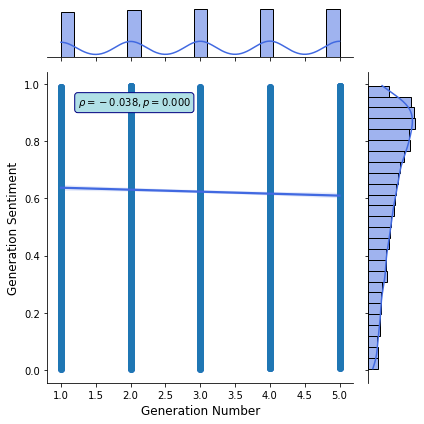

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

# a = np.random.rand(10)
# b = a * 2 + a ** 5

# print("The Rho is {}".format(np.corrcoef(a, b)[0][1]))

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Generation Sentiment', size=12)
plt.tight_layout()
plt.show()

In [ ]:
x = []
y = []
for num in sentiment_dic:
  y.append(sum(sentiment_dic[num])/len(sentiment_dic[num]))
  x.append(int(num))

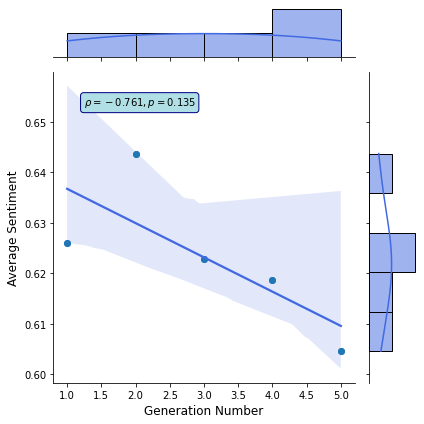

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

# a = np.random.rand(10)
# b = a * 2 + a ** 5

# print("The Rho is {}".format(np.corrcoef(a, b)[0][1]))

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [4]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 4.4 MB 61.0 MB/s 
     |████████████████████████████████| 1.2 MB 54.9 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.1 MB/s 
     |████████████████████████████████| 596 kB 62.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=3b362065032a0b957231192707f79a2c29834af307578a1a610673ffa98344a1
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


/usr/local/lib/python3.7/dist-packages/huggingface_hub/snapshot_download.py:11: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [5]:
import math 
def dist(r1, r2):
  #literally just sqrt(sum(i = 0 -> n, (r1[i] - r2[i])^2)), or the euclidian distance between these two embedding vectors
  d = [(a - b)**2 for a, b in zip(r1, r2)]
  d = sum(d)**.5
  return d

In [ ]:
#semantic exploration vs average sentiment
#there are 6 vignettes that each person answers
id_exploration = {}
for id, group in df.groupby("id"):
  if id not in id_exploration:
    id_exploration[id] = 0
  distance = 0
  len_responses = 0
  for vign, group2 in group.groupby("context"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      embeddings.append(model.encode(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        id_exploration[id] += dist(embeddings[i], embeddings[j])
  id_exploration[id] /= len_responses


In [ ]:
x = []
y = []
for id in id_exploration:
  x.append(individual_sentiment[id])
  y.append(id_exploration[id])

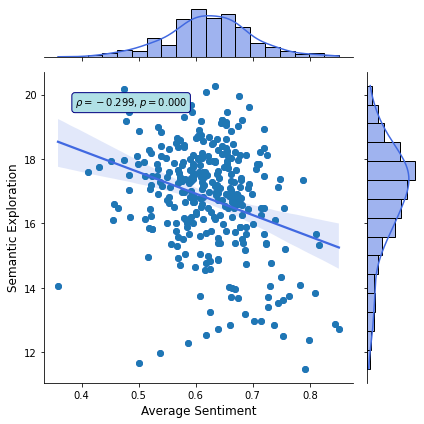

In [ ]:
#display adjusted exploration vs average sentiment 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Sentiment', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
# #for Jonathan - Avg. Senitment vs Exploration 
# from google.colab import files
# sn = pd.DataFrame([sentiment, distances])
# sn = sn.transpose()
# sn.columns = ['average sentiment', 'exploration']
# sn.to_csv('average_sentiment_vs_exploration_study1.csv')
# sn.head(30)

# files.download('average_sentiment_vs_exploration_study1.csv')

In [ ]:
# Semantic exploration vs generation number 
exploration = {}
#here, these lists will be used to plot several of the points individually
nums = []
exp = []
for id, group in df.groupby("id"):
  #this will track the number of generations there were for a given ith index - shouldn't be meaningful here, but might be in study 2, where there aren't as many 6th possiblities 
  answers = 0
  for pnum, group2 in group.groupby("answer"):
    if pnum not in exploration: 
      exploration[pnum] = 0
    embeddings = []
    for response in group2['response']:
      if not pd.isna(response):
        embeddings.append(model.encode(response).tolist())
    distance = 0
    answers += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[pnum] = dist(embeddings[i], embeddings[j]) + exploration.get(pnum)
        distance += dist(embeddings[i], embeddings[j])
    nums.append(pnum)
    exp.append(distance/len(embeddings))
  #here, we will average by the number of ith possibilites just to control for discrepancy
  exploration[pnum] /= answers 

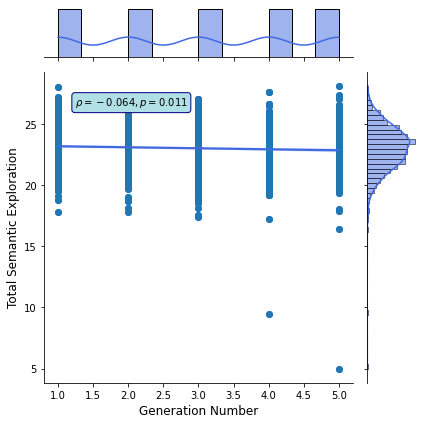

In [ ]:
#plot semantic exploration vs generation number (more data points)
g = sns.jointplot(x=nums, y=exp, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(nums, exp)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(nums, exp)
g.set_axis_labels(xlabel='Generation Number', ylabel='Total Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
# #for Jonathan - Exploration v Generation Number
# from google.colab import files
# sn = pd.DataFrame([exp, nums])
# sn = sn.transpose()
# sn.columns = ['Exploration', 'Generation Number']
# sn.to_csv('explorlation_vs_generation_number_study1.csv')
# sn.head(30)

# files.download('explorlation_vs_generation_number_study1.csv')

In [ ]:
x = []
y = []
for pnum in exploration: 
  x.append(pnum)
  y.append(exploration.get(pnum))

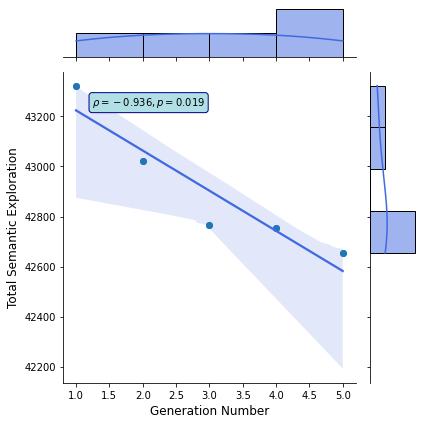

In [ ]:
#plot semantic exploration vs generation number
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Total Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#Semantic dissimilarity vs generation number 

#for every participant map embeddings for ith possibility to ith possibility
escores = {}
for id, participant in df.groupby('id'):
  if id not in escores:
      escores[id] = {}
  for pos_num, group in participant.groupby('answer'):
    if pos_num not in escores[id]:
      escores[id][pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        escores[id][pos_num].append(model.encode(generation))

#create a localizing vector for the ith generation
for id in escores: 
  for pnum in escores.get(id):
    df = pd.DataFrame(escores.get(id).get(pnum))
    df = df.mean(axis=0)
    escores.get(id)[pnum] = df.tolist()

In [ ]:
# aggregate all of the localizing vectors for their respective possibilties
edic = {}
for id in escores: 
  for pnum in escores.get(id):
    if pnum not in edic:
      edic[pnum] = []
    edic.get(pnum).append(escores.get(id).get(pnum))

In [ ]:
def total_variation(e):
  variation = 0
  count = 0
  for i in range(len(e)):
    for j in range(i+1, len(e)):
      variation += dist(e[i], e[j])
      count += 1
      if count%10000==0:
        print("done")
  return variation

In [ ]:
# do we need to adjust for the number of localizing vectors? In theory, no, because every participant should have answered all 5 questions at least once, in one of their vignettes...
x = []
y = []
for pnum in edic:
  x.append(pnum)
  y.append(total_variation(edic.get(pnum)))

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


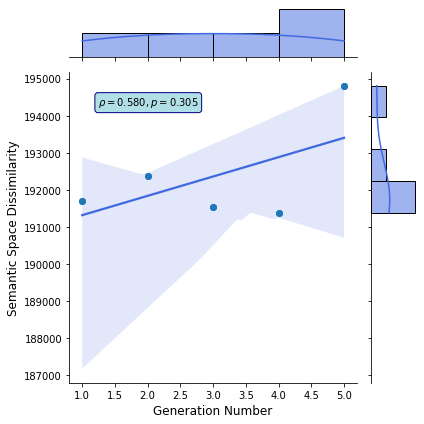

In [ ]:
# displaying total differences
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Space Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [ ]:
# for jonathan - Semantic dissimilarity v. generation number 
distance = []
nums = []
for pnum in edic:
  for i in range(len(edic[pnum])):
    for j in range(i, len(edic[pnum])):
      distance.append(dist(edic[pnum][i], edic[pnum][j]))
      nums.append(pnum)
x = nums
y = distance

In [ ]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
i = 0 
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  i += 1

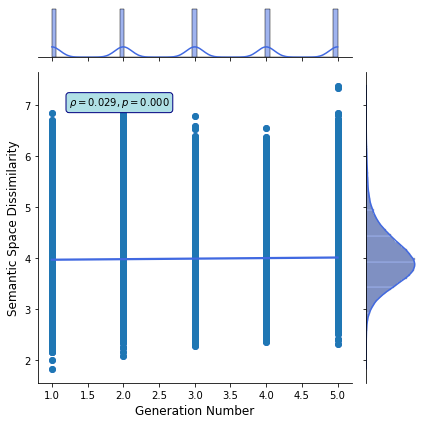

In [ ]:
# displaying distances between any two localizing vectors
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Space Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [2]:
m1 = {
  1:"Heinz's wife has recently fallen ill and needs an expensive medication that is not covered by her medical insurance. They don't have the money needed to purchase the expensive prescription, but they know that it's vital for her to have it if she is going to recover.",
  2:"Josh is on the way to the airport to catch a flight to a hunting safari in Africa. He leaves with plenty of time to make it there, but his car breaks down on the highway. Now Josh is sitting in his car near a busy intersection, and knows he needs to get to airport soon if he is going to catch his flight.",
  3:"Brian is the evening manager at a bakery. Near the end of the day, he realizes that $50.75 is missing from the register and that he is responsible for accounting for the money at the end of the day. Brian knows he has to make sure the register is balanced or he might lose his job.",
  4:"Liz decides to go to the gym on her lunch break to play a game of racquetball with a friend. When she gets to the gym, she realizes that her membership has expired since she last went. Since she left her phone at her desk in the office, she has no way of letting her friend know.",
  5:"Mary is about to go to her final class of the day when she remembers that there is a homework assignment that is due. Mary's mom accidentally took her homework assignment out of her backpack when she was making room for her lunch. Now Mary has nothing to turn in for credit.",
  6:"Brad and some friends are hiking through the mountains in the Canadian wilderness. A couple of days into their hike, Brad realizes that they are lost. He knows that a rescue crew could arrive before long, but it is extremely cold and they don't have much food or water left.",
  7:"Darya is on her way to a concert with her friends. As they approach the entrance her friend Ted realizes he forgot his ticket at his house. The concert is about to start and Ted would likely miss most of the concert if he returned to his house for his ticket.",
  8:"Eunice is sunbathing at the beach next to a family with young children. When the family is playing in the water, she sees a teenager begin to go through their belongings but she isn't sure whether or not he's part of the family.",
  9:"Eamon is driving home on a two-lane road and thinks the driver ahead of him is intoxicated. The car has been slowly drifting between the two lanes and is currently driving in the middle of road.",
  10:"Cameron is filling up his car at a gas station on his way home from work when a woman approaches him to ask for a ride to a nearby city. The city is in the same direction as his house but it's 10 miles further than he planned to go.",
  11:"Erica is leaving the mall on a hot summer day. In the parking lot, she notices a dog in the back of a car without any of its windows open. The dog is panting heavily and looks tired.",
  12:"Carl is a chef on his way to a food festival in Chicago. He is in line to go through security at the airport when he realizes he accidentally brought a large knife in his bag.",
  13:"Daniel is the ring bearer at his sister's wedding. 10 minutes into the ceremony, he reaches into his pocket but the ring isn't there. He realizes he left it on the seat next to him in the taxi.",
  14:"Andy's mother just died and without her, his father is unable to take care of himself. Andy can't afford to put his father in a retirement home and his apartment has barely enough room for one person.",
  15:"Ahmed is the captain of a 50-passenger cruise ship. Four days into their trip they get caught in a storm and the engine breaks under the pressure. They are now stranded at sea. A rescue boat is on its way but might not arrive for a week. Their food supplies are quickly dwindling and Ahmed isn't sure what to instruct the passengers and crew.",
  16:"Eva and Todd are on a mountain climbing trip in Arizona. In the middle of their longest day Todd slips and gets his arm trapped in a crevice. Eva tries calling 911 but she has no service. The sun is beating down on them and Eva is worried that she might be getting dehydrated as she unsuccessfully tries to get his arm out of the rock",
  17:"Jeff works the night shift at a 24/7 convenience store. Every day at 7am the owner of the store, Jeff's boss, takes over for the morning shift. Today, Jeff has an important court appointment at 8am but his boss hasn't shown up yet and isn't returning his calls.",
  18:"Shania is competing in a 100-mile dogsledding race in Minnesota. She hopes to come in first and use the prize money to pay for her college tuition. Halfway through the race she finds one of her competitors lying unconscious next to his crashed sled.",
}
m2 = {
  1:"Your spouse has recently fallen ill and needs an expensive medication that is not covered by your medical insurance. You don't have the money needed to purchase the expensive prescription, but you know that it's vital for them to have it if they are going to recover.",
  2:"You are on the way to the airport to catch a flight to a hunting safari in Africa. You leave with plenty of time to make it there, but your car breaks down on the highway. Now you are sitting in your car near a busy intersection, and know you need to get to airport soon if you are going to catch your flight.",
  3:"You are the evening manager at a bakery. Near the end of the day, you realize that $50.75 is missing from the register and that you are responsible for accounting for the money at the end of the day. You know you have to make sure the register is balanced or you might lose your job.",
  4:"You decide to go to the gym on your lunch break to play a game of racquetball with a friend. When you get to the gym, you realize that your membership has expired since you last went. Since you left your phone at your desk in the office, you have no way of letting your friend know.",
  5:"You are an elementary school student about to go to your final class of the day when you remember that there is a homework assignment that is due. Your mom accidentally took your homework assignment out of your backpack when she was making room for your lunch. Now you have nothing to turn in for credit.",
  6:"You are hiking with some friends through the mountains in the Canadian wilderness. A couple of days into your hike, you realize that you are lost. You know that a rescue crew could arrive before long, but it is extremely cold and you don't have much food or water left.",
  7:"You are on your way to a concert with your friends. As you approach the entrance your friend Ted realizes he forgot his ticket at his house. The concert is about to start and Ted would likely miss most of the concert if he returned to his house for his ticket.",
  8:"You are sunbathing at the beach next to a family with young children. When the family is playing in the water, you see a teenager begin to go through their belongings but you're not sure whether or not he's part of the family.",
  9:"You are driving home on a two-lane road and think the driver ahead of you is intoxicated. The car has been slowly drifting between the two lanes and is currently driving in the middle of road.",
  10:"You are filling up your car at a gas station on your way home from work when a woman approaches you to ask for a ride to a nearby city. The city is in the same direction as your house but it's 10 miles further than you planned to go.",
  11:"You are leaving the mall on a hot summer day. In the parking lot, you notice a dog in the back of a car without any of its windows open. The dog is panting heavily and looks tired.",
  12:"You are a chef on your way to a food festival in Chicago. You are in line to go through security at the airport when you realize you accidentally brought a large knife in your bag.",
  13:"You are the ring bearer at your sister's wedding. 10 minutes into the ceremony, you reach into your pocket but the ring isn't there. You realize you left it on the seat next to you in the taxi.",
  14:"Your mother just died and, without her, your father is unable to take care of himself. You can't afford to put him in a retirement home and your apartment has barely enough room for one person.",
  15:"You are the captain of a 50-passenger cruise ship. Four days into your trip, you get caught in a storm and the engine breaks under the pressure. You are now stranded at sea. A rescue boat is on its way but might not arrive for a week. The food supplies are quickly dwindling and you aren't sure what to instruct the passengers and crew.",
  16:"You and your friend Todd are on a mountain climbing trip in Arizona. In the middle of your longest day Todd slips and gets his arm trapped in a crevice. You try calling 911 but you have no service. The sun is beating down on you and you're worried that you might be getting dehydrated as you unsuccessfully try to get Todd's arm out of the rock.",
  17:"You work the night shift at a 24/7 convenience store. Every day at 7am the owner of the store, your boss, takes over for the morning shift. Today, you have an important court appointment at 8am but your boss hasn't shown up yet and isn't returning his calls.",
  18:"You are competing in a 100-mile dogsledding race in Minnesota. You hope to come in first and use the prize money to pay for your college tuition. Halfway through the race you find one of your competitors lying unconscious next to their crashed sled."
}

In [7]:
# Eli's study should have used the conexts in m1
m_embeddings = {}
for key in m1:
  m_embeddings[key] = model.encode(m1.get(key))

In [8]:
shift = [0]*5
#individual shift points
x = []
y = []

In [9]:
for vign, group in df.groupby("context"):
  for pnum, group2 in group.groupby("answer"):
    for response in group2['response']:
      if not pd.isna(response):
        y.append(dist(model.encode(response), m_embeddings.get(vign)))
        x.append(pnum)
        shift[pnum-1] += x[-1]


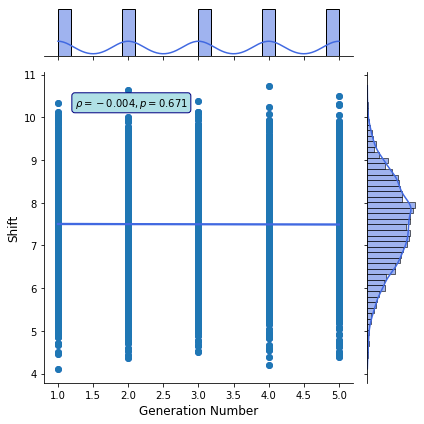

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Shift', size=12)
plt.tight_layout()
plt.show()

In [13]:
number = [i for i in range(5)]
x = np.array(number)
y = np.array(shift)

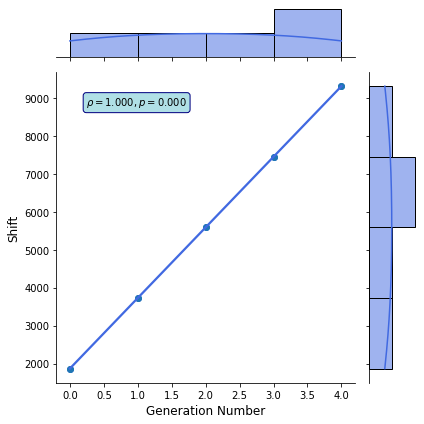

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

# a = np.random.rand(10)
# b = a * 2 + a ** 5

# print("The Rho is {}".format(np.corrcoef(a, b)[0][1]))

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Shift', size=12)
plt.tight_layout()
plt.show()